In [1]:
import datetime
import gc
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import warnings

from contextlib import contextmanager
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

/Users/aleksandrbojko/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

FEATS_EXCLUDED = ['first_active_month', 'target', 'card_id', 'outliers',
                  'hist_purchase_date_max', 'hist_purchase_date_min', 'hist_card_id_size',
                  'new_purchase_date_max', 'new_purchase_date_min', 'new_card_id_size',
                  'OOF_PRED', 'month_0']

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# rmse
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns
    
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [3]:
# preprocessing train & test
def train_test(num_rows=None):

    # load csv
    train_df = pd.read_csv('data/train.csv', index_col=['card_id'], nrows=num_rows)
    test_df = pd.read_csv('data/test.csv', index_col=['card_id'], nrows=num_rows)

    print("Train samples: {}, test samples: {}".format(len(train_df), len(test_df)))

    # outlier
    train_df['outliers'] = 0
    train_df.loc[train_df['target'] < -30, 'outliers'] = 1

    # set target as nan
    test_df['target'] = np.nan

    # merge
    df = train_df.append(test_df)

    del train_df, test_df
    gc.collect()

    # to datetime
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])

    # datetime features
    df['quarter'] = df['first_active_month'].dt.quarter
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

    df['days_feature1'] = df['elapsed_time'] * df['feature_1']
    df['days_feature2'] = df['elapsed_time'] * df['feature_2']
    df['days_feature3'] = df['elapsed_time'] * df['feature_3']

    df['days_feature1_ratio'] = df['feature_1'] / df['elapsed_time']
    df['days_feature2_ratio'] = df['feature_2'] / df['elapsed_time']
    df['days_feature3_ratio'] = df['feature_3'] / df['elapsed_time']

    # one hot encoding
    df, cols = one_hot_encoder(df, nan_as_category=False)

    for f in ['feature_1','feature_2','feature_3']:
        order_label = df.groupby([f])['outliers'].mean()
        df[f] = df[f].map(order_label)

    df['feature_sum'] = df['feature_1'] + df['feature_2'] + df['feature_3']
    df['feature_mean'] = df['feature_sum']/3
    df['feature_max'] = df[['feature_1', 'feature_2', 'feature_3']].max(axis=1)
    df['feature_min'] = df[['feature_1', 'feature_2', 'feature_3']].min(axis=1)
    df['feature_var'] = df[['feature_1', 'feature_2', 'feature_3']].std(axis=1)

    return df


In [60]:
# preprocessing historical transactions
def historical_transactions(num_rows=None):
    # load csv
    hist_df = pd.read_csv('data/historical_transactions.csv', nrows=num_rows)

    # fillna
    hist_df['category_2'].fillna(1.0,inplace=True)
    hist_df['category_3'].fillna('A',inplace=True)
    hist_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    hist_df['installments'].replace(-1, np.nan,inplace=True)
    hist_df['installments'].replace(999, np.nan,inplace=True)

    # trim
    hist_df['purchase_amount'] = hist_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_1'] = hist_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    hist_df['category_3'] = hist_df['category_3'].map({'A':0, 'B':1, 'C':2})

    # datetime features
    hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])
    hist_df['month'] = hist_df['purchase_date'].dt.month
    hist_df['day'] = hist_df['purchase_date'].dt.day
    hist_df['hour'] = hist_df['purchase_date'].dt.hour
    hist_df['weekofyear'] = hist_df['purchase_date'].dt.weekofyear
    hist_df['weekday'] = hist_df['purchase_date'].dt.weekday
    hist_df['weekend'] = (hist_df['purchase_date'].dt.weekday >=5).astype(int)

    # additional features
    hist_df['price'] = hist_df['purchase_amount'] / hist_df['installments']

    #Christmas : December 25 2017
    hist_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Mothers Day: May 14 2017
    hist_df['Mothers_Day_2017']=(pd.to_datetime('2017-06-04')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #fathers day: August 13 2017
    hist_df['fathers_day_2017']=(pd.to_datetime('2017-08-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    hist_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Valentine's Day : 12th June, 2017
    hist_df['Valentine_Day_2017']=(pd.to_datetime('2017-06-12')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    hist_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #2018
    #Mothers Day: May 13 2018
    hist_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-hist_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    hist_df['month_diff'] = ((datetime.datetime.today() - hist_df['purchase_date']).dt.days)//30
    hist_df['month_diff'] += hist_df['month_lag']

    # additional features
    hist_df['duration'] = hist_df['purchase_amount']*hist_df['month_diff']
    hist_df['amount_month_ratio'] = hist_df['purchase_amount']/hist_df['month_diff']

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['max','min','mean','var','skew']
    aggs['authorized_flag'] = ['mean']
    aggs['weekend'] = ['mean'] # overwrite
    aggs['weekday'] = ['mean'] # overwrite
    aggs['day'] = ['nunique', 'mean', 'min'] # overwrite
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['sum','mean','max','min','var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Mothers_Day_2017'] = ['mean']
    aggs['fathers_day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Valentine_Day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean','min','max','var','skew']
    aggs['amount_month_ratio']=['mean','min','max','var','skew']

    for col in ['category_2','category_3']:
        hist_df[col+'_mean'] = hist_df.groupby([col])['purchase_amount'].transform('mean')
        hist_df[col+'_min'] = hist_df.groupby([col])['purchase_amount'].transform('min')
        hist_df[col+'_max'] = hist_df.groupby([col])['purchase_amount'].transform('max')
        hist_df[col+'_sum'] = hist_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    hist_df = hist_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    hist_df.columns = pd.Index([e[0] + "_" + e[1] for e in hist_df.columns.tolist()])
    hist_df.columns = ['hist_'+ c for c in hist_df.columns]

    hist_df['hist_purchase_date_diff'] = (hist_df['hist_purchase_date_max']-hist_df['hist_purchase_date_min']).dt.days
    hist_df['hist_purchase_date_average'] = hist_df['hist_purchase_date_diff']/hist_df['hist_card_id_size']
    hist_df['hist_purchase_date_uptonow'] = (datetime.datetime.today()-hist_df['hist_purchase_date_max']).dt.days
    hist_df['hist_purchase_date_uptomin'] = (datetime.datetime.today()-hist_df['hist_purchase_date_min']).dt.days

    # reduce memory usage
    hist_df = reduce_mem_usage(hist_df)

    return hist_df
    
# preprocessing new_merchant_transactions
def new_merchant_transactions(num_rows=None):
    # load csv
    new_merchant_df = pd.read_csv('data/new_merchant_transactions.csv', nrows=num_rows)

    # fillna
    new_merchant_df['category_2'].fillna(1.0,inplace=True)
    new_merchant_df['category_3'].fillna('A',inplace=True)
    new_merchant_df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
    new_merchant_df['installments'].replace(-1, np.nan,inplace=True)
    new_merchant_df['installments'].replace(999, np.nan,inplace=True)

    # trim
    new_merchant_df['purchase_amount'] = new_merchant_df['purchase_amount'].apply(lambda x: min(x, 0.8))

    # Y/N to 1/0
    new_merchant_df['authorized_flag'] = new_merchant_df['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_1'] = new_merchant_df['category_1'].map({'Y': 1, 'N': 0}).astype(int)
    new_merchant_df['category_3'] = new_merchant_df['category_3'].map({'A':0, 'B':1, 'C':2}).astype(int)

    # datetime features
    new_merchant_df['purchase_date'] = pd.to_datetime(new_merchant_df['purchase_date'])
    new_merchant_df['month'] = new_merchant_df['purchase_date'].dt.month
    new_merchant_df['day'] = new_merchant_df['purchase_date'].dt.day
    new_merchant_df['hour'] = new_merchant_df['purchase_date'].dt.hour
    new_merchant_df['weekofyear'] = new_merchant_df['purchase_date'].dt.weekofyear
    new_merchant_df['weekday'] = new_merchant_df['purchase_date'].dt.weekday
    new_merchant_df['weekend'] = (new_merchant_df['purchase_date'].dt.weekday >=5).astype(int)

    # additional features
    new_merchant_df['price'] = new_merchant_df['purchase_amount'] / new_merchant_df['installments']

    #Christmas : December 25 2017
    new_merchant_df['Christmas_Day_2017']=(pd.to_datetime('2017-12-25')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Childrens day: October 12 2017
    new_merchant_df['Children_day_2017']=(pd.to_datetime('2017-10-12')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)
    #Black Friday : 24th November 2017
    new_merchant_df['Black_Friday_2017']=(pd.to_datetime('2017-11-24') - new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    #Mothers Day: May 13 2018
    new_merchant_df['Mothers_Day_2018']=(pd.to_datetime('2018-05-13')-new_merchant_df['purchase_date']).dt.days.apply(lambda x: x if x > 0 and x < 100 else 0)

    new_merchant_df['month_diff'] = ((datetime.datetime.today() - new_merchant_df['purchase_date']).dt.days)//30
    new_merchant_df['month_diff'] += new_merchant_df['month_lag']

    # additional features
    new_merchant_df['duration'] = new_merchant_df['purchase_amount']*new_merchant_df['month_diff']
    new_merchant_df['amount_month_ratio'] = new_merchant_df['purchase_amount']/new_merchant_df['month_diff']

    # reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    col_unique =['subsector_id', 'merchant_id', 'merchant_category_id']
    col_seas = ['month', 'hour', 'weekofyear', 'weekday', 'day']

    aggs = {}
    for col in col_unique:
        aggs[col] = ['nunique']

    for col in col_seas:
        aggs[col] = ['nunique', 'mean', 'min', 'max']

    aggs['purchase_amount'] = ['sum','max','min','mean','var','skew']
    aggs['installments'] = ['sum','max','mean','var','skew']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var','skew']
    aggs['month_diff'] = ['mean','var','skew']
    aggs['weekend'] = ['mean']
    aggs['month'] = ['mean', 'min', 'max']
    aggs['weekday'] = ['mean', 'min', 'max']
    aggs['category_1'] = ['mean']
    aggs['category_2'] = ['mean']
    aggs['category_3'] = ['mean']
    aggs['card_id'] = ['size','count']
    aggs['price'] = ['mean','max','min','var']
    aggs['Christmas_Day_2017'] = ['mean']
    aggs['Children_day_2017'] = ['mean']
    aggs['Black_Friday_2017'] = ['mean']
    aggs['Mothers_Day_2018'] = ['mean']
    aggs['duration']=['mean','min','max','var','skew']
    aggs['amount_month_ratio']=['mean','min','max','var','skew']

    for col in ['category_2','category_3']:
        new_merchant_df[col+'_mean'] = new_merchant_df.groupby([col])['purchase_amount'].transform('mean')
        new_merchant_df[col+'_min'] = new_merchant_df.groupby([col])['purchase_amount'].transform('min')
        new_merchant_df[col+'_max'] = new_merchant_df.groupby([col])['purchase_amount'].transform('max')
        new_merchant_df[col+'_sum'] = new_merchant_df.groupby([col])['purchase_amount'].transform('sum')
        aggs[col+'_mean'] = ['mean']

    new_merchant_df = new_merchant_df.reset_index().groupby('card_id').agg(aggs)

    # change column name
    new_merchant_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_merchant_df.columns.tolist()])
    new_merchant_df.columns = ['new_'+ c for c in new_merchant_df.columns]

    new_merchant_df['new_purchase_date_diff'] = (new_merchant_df['new_purchase_date_max']-new_merchant_df['new_purchase_date_min']).dt.days
    new_merchant_df['new_purchase_date_average'] = new_merchant_df['new_purchase_date_diff']/new_merchant_df['new_card_id_size']
    new_merchant_df['new_purchase_date_uptonow'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_max']).dt.days
    new_merchant_df['new_purchase_date_uptomin'] = (datetime.datetime.today()-new_merchant_df['new_purchase_date_min']).dt.days

    # reduce memory usage
    new_merchant_df = reduce_mem_usage(new_merchant_df)

    return new_merchant_df

# additional features
def additional_features(df):
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_last_buy'] = (df['hist_purchase_date_max'] - df['first_active_month']).dt.days
    df['new_first_buy'] = (df['new_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_last_buy'] = (df['new_purchase_date_max'] - df['first_active_month']).dt.days

    date_features=['hist_purchase_date_max','hist_purchase_date_min',
                   'new_purchase_date_max', 'new_purchase_date_min']

    for f in date_features:
        df[f] = df[f].astype(np.int64) * 1e-9

    df['card_id_total'] = df['new_card_id_size']+df['hist_card_id_size']
    df['card_id_cnt_total'] = df['new_card_id_count']+df['hist_card_id_count']
    df['card_id_cnt_ratio'] = df['new_card_id_count']/df['hist_card_id_count']
    df['purchase_amount_total'] = df['new_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_mean'] = df['new_purchase_amount_mean']+df['hist_purchase_amount_mean']
    df['purchase_amount_max'] = df['new_purchase_amount_max']+df['hist_purchase_amount_max']
    df['purchase_amount_min'] = df['new_purchase_amount_min']+df['hist_purchase_amount_min']
    df['purchase_amount_ratio'] = df['new_purchase_amount_sum']/df['hist_purchase_amount_sum']
    df['month_diff_mean'] = df['new_month_diff_mean']+df['hist_month_diff_mean']
    df['month_diff_ratio'] = df['new_month_diff_mean']/df['hist_month_diff_mean']
    df['month_lag_mean'] = df['new_month_lag_mean']+df['hist_month_lag_mean']
    df['month_lag_max'] = df['new_month_lag_max']+df['hist_month_lag_max']
    df['month_lag_min'] = df['new_month_lag_min']+df['hist_month_lag_min']
    df['category_1_mean'] = df['new_category_1_mean']+df['hist_category_1_mean']
    df['installments_total'] = df['new_installments_sum']+df['hist_installments_sum']
    df['installments_mean'] = df['new_installments_mean']+df['hist_installments_mean']
    df['installments_max'] = df['new_installments_max']+df['hist_installments_max']
    df['installments_ratio'] = df['new_installments_sum']/df['hist_installments_sum']
    df['price_total'] = df['purchase_amount_total'] / df['installments_total']
    df['price_mean'] = df['purchase_amount_mean'] / df['installments_mean']
    df['price_max'] = df['purchase_amount_max'] / df['installments_max']
    df['duration_mean'] = df['new_duration_mean']+df['hist_duration_mean']
    df['duration_min'] = df['new_duration_min']+df['hist_duration_min']
    df['duration_max'] = df['new_duration_max']+df['hist_duration_max']
    df['amount_month_ratio_mean']=df['new_amount_month_ratio_mean']+df['hist_amount_month_ratio_mean']
    df['amount_month_ratio_min']=df['new_amount_month_ratio_min']+df['hist_amount_month_ratio_min']
    df['amount_month_ratio_max']=df['new_amount_month_ratio_max']+df['hist_amount_month_ratio_max']
    df['new_CLV'] = df['new_card_id_count'] * df['new_purchase_amount_sum'] / df['new_month_diff_mean']
    df['hist_CLV'] = df['hist_card_id_count'] * df['hist_purchase_amount_sum'] / df['hist_month_diff_mean']
    df['CLV_ratio'] = df['new_CLV'] / df['hist_CLV']
    
    new_pur = data_new.groupby('card_id')['purchase_amount'].agg(['sum', 'mean']).reset_index()
    new_pur.columns = ['card_id', 'sum_new', 'mean_new']

    his_pur = data_hist.groupby('card_id')['purchase_amount'].agg(['sum', 'mean']).reset_index()
    his_pur.columns = ['card_id', 'sum_his', 'mean_his']
    new_pur['sum_new/sum_his'] = new_pur['sum_new'] / his_pur['sum_his']
    new_pur['mean_new/mean_his'] = new_pur['mean_new'] / his_pur['mean_his']
    
    df_pur = pd.DataFrame({'card_id': new_pur['card_id'], 'sum_new/sum_his': new_pur['sum_new/sum_his'],
                      'mean_new/mean_his': new_pur['mean_new/mean_his']})
    
    
    df = pd.merge(df, df_pur, on='card_id', how='left')

    return df

# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # params optimized by optuna
        params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)
                }

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)

    if not debug:
        # save submission file
        test_df.loc[:,'target'] = sub_preds
        test_df = test_df.reset_index()
        test_df[['card_id', 'target']].to_csv(submission_file_name, index=False)
        
    return train_df, test_df, sub_preds


In [61]:
def main(debug=False):
    num_rows = 10000 if debug else None
    with timer("train & test"):
        df = train_test(num_rows)
    with timer("historical transactions"):
        df = pd.merge(df, historical_transactions(num_rows), on='card_id', how='outer')
    with timer("new merchants"):
        df = pd.merge(df, new_merchant_transactions(num_rows), on='card_id', how='outer')
    with timer("additional features"):
        df = additional_features(df)
    with timer("split train & test"):
        train_df = df[df['target'].notnull()]
        test_df = df[df['target'].isnull()]
        del df
        gc.collect()
    with timer("Run LightGBM with kfold"):
        kfold_lightgbm(train_df, test_df, num_folds=5, stratified=False, debug=debug)


Train samples: 201917, test samples: 123623
train & test - done in 1s
Memory usage after optimization is: 1832.41 MB
Decreased by 73.4%
Memory usage after optimization is: 56.19 MB
Decreased by 57.6%
historical transactions - done in 932s
Memory usage after optimization is: 117.94 MB
Decreased by 71.9%
Memory usage after optimization is: 44.53 MB
Decreased by 57.6%
new merchants - done in 476s
additional features - done in 7s
split train & test - done in 1s
Starting LightGBM. Train shape: (201917, 205), test shape: (123623, 205)
Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 3.63514	test's rmse: 3.79217
[200]	train's rmse: 3.55484	test's rmse: 3.75879
[300]	train's rmse: 3.50444	test's rmse: 3.74659
[400]	train's rmse: 3.46757	test's rmse: 3.7416
[500]	train's rmse: 3.43981	test's rmse: 3.73932
[600]	train's rmse: 3.41734	test's rmse: 3.73867
[700]	train's rmse: 3.39695	test's rmse: 3.73854
[800]	train's rmse: 3.37682	test's rmse: 3.73845
[900]	train

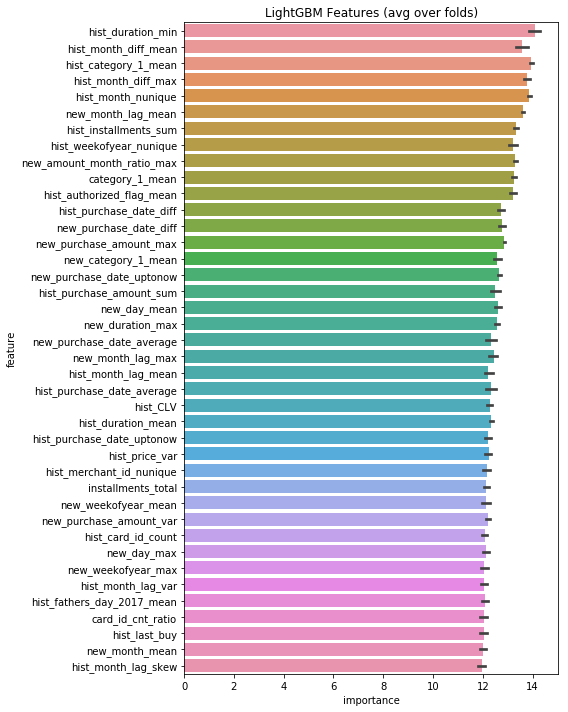

In [62]:
if __name__ == "__main__":
    submission_file_name = "submission_lol.csv"
    with timer("Full model run"):
        main(debug=False)

In [14]:
df = train_test()

Train samples: 201917, test samples: 123623


In [16]:
hist = historical_transactions()

Memory usage after optimization is: 1832.41 MB
Decreased by 73.4%
Memory usage after optimization is: 56.19 MB
Decreased by 57.6%


In [17]:
new = new_merchant_transactions()

Memory usage after optimization is: 117.94 MB
Decreased by 71.9%
Memory usage after optimization is: 44.53 MB
Decreased by 57.6%


In [24]:
hist

,hist_subsector_id_nunique,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_month_nunique,hist_month_mean,hist_month_min,hist_month_max,hist_hour_nunique,hist_hour_mean,hist_hour_min,...,hist_amount_month_ratio_min,hist_amount_month_ratio_max,hist_amount_month_ratio_var,hist_amount_month_ratio_skew,hist_category_2_mean_mean,hist_category_3_mean_mean,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,hist_purchase_date_uptomin
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_00007093c1,13,29,18,12,6.375000,1,12,18,14.414062,0,...,-0.065552,0.072754,0.000480,2.900391,-0.593750,-0.552246,377,2.529297,355,733
C_ID_0001238066,17,65,29,6,7.308594,1,12,20,14.742188,0,...,-0.066223,0.064026,0.000257,4.007812,-0.605957,-0.509766,151,1.227539,355,506
C_ID_0001506ef0,12,28,19,11,6.804688,1,12,15,12.609375,0,...,-0.067200,0.066650,0.001277,2.394531,-0.591309,-0.639160,398,6.031250,365,764
C_ID_0001793786,24,119,48,10,6.671875,1,10,21,15.609375,0,...,-0.049683,0.053345,0.000932,1.284180,-0.601562,-0.639160,283,1.310547,473,757
C_ID_000183fdda,21,73,36,7,6.882812,1,12,19,16.468750,0,...,-0.065979,0.066650,0.000963,2.515625,-0.592285,-0.511230,202,1.402344,356,559
C_ID_00024e244b,8,19,10,11,6.457031,1,12,17,12.617188,0,...,-0.067139,0.066650,0.000595,3.550781,-0.591309,-0.638184,399,5.699219,376,776
C_ID_0002709b5a,13,35,18,11,7.699219,1,12,18,11.765625,0,...,-0.061920,-0.028061,0.000044,1.964844,-0.598633,-0.544922,402,5.507812,363,765
C_ID_00027503e2,6,12,7,9,7.714844,1,12,10,12.523438,0,...,-0.062012,-0.056458,0.000002,-3.554688,-0.591797,-0.639648,237,5.644531,394,631
C_ID_000298032a,10,20,12,9,6.101562,1,12,9,15.929688,0,...,-0.055359,0.061523,0.000427,5.234375,-0.606445,-0.639648,345,11.500000,389,734


In [26]:
df = pd.merge(df, hist, on='card_id', how='left')

In [28]:
df = pd.merge(df, new, on='card_id', how='left')

In [30]:
df = additional_features(df)

In [33]:
train_df = df[df['target'].notnull()]
test_df = df[df['target'].isnull()]

In [34]:
train_df

,feature_1,feature_2,feature_3,first_active_month,outliers,target,quarter,elapsed_time,days_feature1,days_feature2,...,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,0.013145,0.008752,0.011428,2017-06-01,0.0,-0.820283,2.0,626.0,3130.0,1252.0,...,0.503906,-14.335938,-17.515625,6.343750,-0.103943,-0.132935,0.041992,-26.042084,-3688.900635,0.007060
C_ID_3d0044924f,0.010712,0.011385,0.010283,2017-01-01,0.0,0.392913,1.0,777.0,3108.0,777.0,...,0.008919,-17.203125,-19.250000,1.976562,-0.104675,-0.120239,0.006500,-2.035910,-5876.248535,0.000346
C_ID_d639edf6cd,0.010610,0.008752,0.010283,2016-08-01,0.0,0.688056,3.0,930.0,1860.0,1860.0,...,-inf,-15.726562,-16.468750,-9.304688,-0.121033,-0.126709,-0.076904,-0.063654,-106.191795,0.000599
C_ID_186d6a6901,0.010712,0.014166,0.010283,2017-09-01,0.0,0.142495,3.0,534.0,2136.0,1602.0,...,0.058228,-15.593750,-17.703125,2.800781,-0.111206,-0.128418,0.019409,-2.716146,-329.574371,0.008241
C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,2017-11-01,0.0,-0.159749,4.0,473.0,473.0,1419.0,...,0.089355,-13.171875,-17.828125,15.015625,-0.095276,-0.133545,0.110352,-60.754467,-854.037354,0.071138
C_ID_0894217f2f,0.010712,0.008752,0.010283,2016-09-01,0.0,0.871585,3.0,899.0,3596.0,1798.0,...,0.002241,-14.570312,-25.343750,0.638672,-0.040405,-0.070190,0.001770,-0.294613,-23.961697,0.012295
C_ID_7e63323c00,0.010479,0.008752,0.011428,2016-12-01,0.0,0.230129,4.0,808.0,2424.0,1616.0,...,-inf,-17.156250,-17.812500,-14.796875,-0.119812,-0.129272,-0.103271,-1.500651,-4037.486816,0.000372
C_ID_dfa21fc124,0.010479,0.008752,0.011428,2017-09-01,0.0,2.135850,3.0,534.0,1602.0,1068.0,...,-inf,-18.140625,-20.265625,-10.492188,-0.095581,-0.107483,-0.054077,-0.449498,-22.038063,0.020396
C_ID_fe0fdac8ea,0.010610,0.011385,0.010283,2017-08-01,0.0,-0.065406,3.0,565.0,1130.0,565.0,...,-0.277344,-14.546875,-17.140625,-9.984375,-0.101013,-0.119080,-0.069336,-0.210612,-10.888672,0.019342


In [36]:
train_df.head(5)

,feature_1,feature_2,feature_3,first_active_month,outliers,target,quarter,elapsed_time,days_feature1,days_feature2,...,price_max,duration_mean,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio
card_id,,,,,,,,,,,,,,,,,,,,,
C_ID_92a2005557,0.013145,0.008752,0.011428,2017-06-01,0.0,-0.820283,2.0,626.0,3130.0,1252.0,...,0.503906,-14.335938,-17.515625,6.343750,-0.103943,-0.132935,0.041992,-26.042084,-3688.900635,0.007060
C_ID_3d0044924f,0.010712,0.011385,0.010283,2017-01-01,0.0,0.392913,1.0,777.0,3108.0,777.0,...,0.008919,-17.203125,-19.250000,1.976562,-0.104675,-0.120239,0.006500,-2.035910,-5876.248535,0.000346
C_ID_d639edf6cd,0.010610,0.008752,0.010283,2016-08-01,0.0,0.688056,3.0,930.0,1860.0,1860.0,...,-inf,-15.726562,-16.468750,-9.304688,-0.121033,-0.126709,-0.076904,-0.063654,-106.191795,0.000599
C_ID_186d6a6901,0.010712,0.014166,0.010283,2017-09-01,0.0,0.142495,3.0,534.0,2136.0,1602.0,...,0.058228,-15.593750,-17.703125,2.800781,-0.111206,-0.128418,0.019409,-2.716146,-329.574371,0.008241
C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,2017-11-01,0.0,-0.159749,4.0,473.0,473.0,1419.0,...,0.089355,-13.171875,-17.828125,15.015625,-0.095276,-0.133545,0.110352,-60.754467,-854.037354,0.071138


In [37]:
data_hist = pd.read_csv('data/historical_transactions.csv')
display(data_hist.info())
data_hist.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 3.0+ GB


None

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [39]:
data_hist['month_lag'].value_counts()

-2     3857276
-1     3627430
 0     3470946
-3     3095651
-4     2639805
-5     2364790
-6     2050048
-7     1769844
-8     1427846
-9     1234724
-10    1085053
-11    1007878
-12     791973
-13     689097
Name: month_lag, dtype: int64

In [38]:
data_new = pd.read_csv('data/new_merchant_transactions.csv')
display(data_new.head(5))
data_new.info()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: float64(2), int64(6), object(6)
memory usage: 209.7+ MB


In [40]:
data_new['month_lag'].value_counts()

1    1027617
2     935414
Name: month_lag, dtype: int64

In [44]:
new_pur = data_new.groupby('card_id')['purchase_amount'].agg(['sum', 'mean']).reset_index()
new_pur.columns = ['card_id', 'sum_new', 'mean_new']

his_pur = data_hist.groupby('card_id')['purchase_amount'].agg(['sum', 'mean']).reset_index()
his_pur.columns = ['card_id', 'sum_his', 'mean_his']



In [45]:
display(new_pur.head(5))
display(his_pur.head(5))

,card_id,sum_new,mean_new
0,C_ID_00007093c1,-1.328524,-0.664262
1,C_ID_0001238066,-14.850055,-0.571156
2,C_ID_0001506ef0,-1.447354,-0.723677
3,C_ID_0001793786,-0.229620,-0.007407
4,C_ID_000183fdda,-6.590778,-0.599162


,card_id,sum_his,mean_his
0,C_ID_00007093c1,-76.845041,-0.515739
1,C_ID_0001238066,-72.447201,-0.589002
2,C_ID_0001506ef0,-34.601879,-0.524271
3,C_ID_0001793786,-36.786013,-0.170306
4,C_ID_000183fdda,-68.837938,-0.478041


In [46]:
new_pur['sum_new/sum_his'] = new_pur['sum_new'] / his_pur['sum_his']
new_pur['mean_new/mean_his'] = new_pur['mean_new'] / his_pur['mean_his']

new_pur.head(5)

,card_id,sum_new,mean_new,sum_new/sum_his,mean_new/mean_his
0,C_ID_00007093c1,-1.328524,-0.664262,0.017288,1.287982
1,C_ID_0001238066,-14.850055,-0.571156,0.204978,0.969702
2,C_ID_0001506ef0,-1.447354,-0.723677,0.041829,1.380349
3,C_ID_0001793786,-0.229620,-0.007407,0.006242,0.043493
4,C_ID_000183fdda,-6.590778,-0.599162,0.095743,1.253368


In [47]:
df_pur = pd.DataFrame({'card_id': new_pur['card_id'], 'sum_new/sum_his': new_pur['sum_new/sum_his'],
                      'mean_new/mean_his': new_pur['mean_new/mean_his']})

In [49]:
train_df = pd.merge(train_df, df_pur, on='card_id', how='left')
test_df = pd.merge(test_df, df_pur, on='card_id', how='left')

train_df.head(5)

,card_id,feature_1,feature_2,feature_3,first_active_month,outliers,target,quarter,elapsed_time,days_feature1,...,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,sum_new/sum_his,mean_new/mean_his
0,C_ID_92a2005557,0.013145,0.008752,0.011428,2017-06-01,0.0,-0.820283,2.0,626.0,3130.0,...,-17.515625,6.343750,-0.103943,-0.132935,0.041992,-26.042084,-3688.900635,0.007060,0.275990,0.935967
1,C_ID_3d0044924f,0.010712,0.011385,0.010283,2017-01-01,0.0,0.392913,1.0,777.0,3108.0,...,-19.250000,1.976562,-0.104675,-0.120239,0.006500,-2.035910,-5876.248535,0.000346,-0.101218,-1.568879
2,C_ID_d639edf6cd,0.010610,0.008752,0.010283,2016-08-01,0.0,0.688056,3.0,930.0,1860.0,...,-16.468750,-9.304688,-0.121033,-0.126709,-0.076904,-0.063654,-106.191795,0.000599,0.032614,1.076275
3,C_ID_186d6a6901,0.010712,0.014166,0.010283,2017-09-01,0.0,0.142495,3.0,534.0,2136.0,...,-17.703125,2.800781,-0.111206,-0.128418,0.019409,-2.716146,-329.574371,0.008241,0.109898,0.989086
4,C_ID_cdbd2c0db2,0.008058,0.014166,0.010283,2017-11-01,0.0,-0.159749,4.0,473.0,473.0,...,-17.828125,15.015625,-0.095276,-0.133545,0.110352,-60.754467,-854.037354,0.071138,0.085225,0.830941


In [50]:
test_df.head(5)

,card_id,feature_1,feature_2,feature_3,first_active_month,outliers,target,quarter,elapsed_time,days_feature1,...,duration_min,duration_max,amount_month_ratio_mean,amount_month_ratio_min,amount_month_ratio_max,new_CLV,hist_CLV,CLV_ratio,sum_new/sum_his,mean_new/mean_his
0,C_ID_0ab67a22ab,0.010479,0.014166,0.011428,2017-04-01,NaN,NaN,2.0,687.0,2061.0,...,-19.812500,-2.068359,-0.087097,-0.112427,-0.010544,-0.390223,-200.461533,0.001947,0.020152,0.967311
1,C_ID_130fd0cbdd,0.010610,0.014166,0.010283,2017-01-01,NaN,NaN,1.0,777.0,1554.0,...,-17.671875,-2.251953,-0.107605,-0.124512,-0.015640,-4.458984,-319.728821,0.013946,-0.453189,-1.712047
2,C_ID_b709037bc5,0.013145,0.011385,0.011428,2017-08-01,NaN,NaN,3.0,565.0,2825.0,...,-15.132812,19.203125,0.014168,-0.105103,0.133301,0.012533,1.863037,0.006727,-0.002849,-0.126779
3,C_ID_d27d835a9f,0.010610,0.011385,0.010283,2017-12-01,NaN,NaN,4.0,443.0,886.0,...,-16.843750,-4.320312,-0.092773,-0.118652,-0.029999,-4.870861,-29.867628,0.163082,0.263339,1.106025
4,C_ID_2b5e3df5c2,0.013145,0.011385,0.011428,2015-12-01,NaN,NaN,4.0,1174.0,5870.0,...,-17.406250,19.203125,-0.055176,-0.125244,0.133301,-0.707520,-426.973694,0.001657,-0.093072,-2.869708


In [51]:
train_df.drop(columns=['card_id'], inplace=True)
test_df.drop(columns=['card_id'], inplace=True)

In [54]:
def kfold_lightgbm(train_df, test_df, num_folds, stratified = False, debug= False):
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['outliers'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['target'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['target'].iloc[valid_idx]

        # set data structure
        lgb_train = lgb.Dataset(train_x,
                                label=train_y,
                                free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x,
                               label=valid_y,
                               free_raw_data=False)

        # params optimized by optuna
        params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**n_fold),
                'bagging_seed':int(2**n_fold),
                'drop_seed':int(2**n_fold)
                }

        reg = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_test],
                        valid_names=['train', 'test'],
                        num_boost_round=10000,
                        early_stopping_rounds= 200,
                        verbose_eval=100
                        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += reg.predict(test_df[feats], num_iteration=reg.best_iteration) / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(reg.feature_importance(importance_type='gain', iteration=reg.best_iteration))
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d RMSE : %.6f' % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)
    
    return sub_preds
#     if not debug:
#         # save submission file
#         test_df.loc[:,'target'] = sub_preds
#         test_df = test_df.reset_index()
#         test_df[['card_id', 'target']].to_csv(submission_file_name, index=False)

In [53]:
submission_file_name = "submission_lol.csv"

In [56]:
sub = kfold_lightgbm(train_df, test_df, num_folds=5, stratified=False, debug=False)

Starting LightGBM. Train shape: (201917, 358), test shape: (123623, 358)


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields hist_purchase_date_max_x, hist_purchase_date_min_x, hist_purchase_date_max_y, hist_purchase_date_min_y